In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

pd.set_option('display.max_columns', None)

In [2]:
# cleaned
df_1 = pd.read_csv('data\consumer_complaints_cleaned.csv')

# labeled
df_2 = pd.read_csv('data\consumer_complaints_labeled.csv')

In [3]:
# combine 2 df
df_combined = pd.concat([df_1, df_2], axis=1)
df_combined

# change data type
df_combined['date_sent_to_company'] = pd.to_datetime(df_combined['date_sent_to_company'], format='%Y-%m-%d')
df_combined['date_received'] = pd.to_datetime(df_combined['date_received'], format='%Y-%m-%d')

# combine labels
combined_labels = []
for i in range(len(df_combined)):
    combined = []
    combined.append(df_combined['light_complaints'][i])
    combined.append(df_combined['mild_complaints'][i])
    combined.append(df_combined['harsh_complaints'][i])
    combined_labels.append(combined)

df_combined['combined_labels'] = combined_labels

combined_labels_new = []
for i in df_combined['combined_labels']:
    temp = ''
    if i[0] == 1:
        temp += 'light'
    if i[1] == 1:
        if temp != '': temp += ', '
        temp += 'mild'
    if i[2] == 1:
        if temp != '': temp += ', '
        temp += 'harsh'
    combined_labels_new.append(temp)

df_combined['combined_labels'] = combined_labels_new
    
df_combined

,complaint_id,date_received,date_sent_to_company,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed,sentence,light_complaints,harsh_complaints,mild_complaints,combined_labels
0,1299258,2015-03-24,2015-03-24,Payday loan,Payday loan,Can't stop charges to bank account,Can't stop charges to bank account,"I took out a Loan from Cash Central XXXX, Al f...",Company chooses not to provide a public response,"Community Choice Financial, Inc.",AL,351XX,Older American,Consent provided,Web,Closed with explanation,Yes,No,Can't stop charges to bank account Can't stop ...,0,1,1,"mild, harsh"
1,1290580,2015-03-19,2015-03-19,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,This dentist appt was back in 2012 and I was u...,Company believes it acted appropriately as aut...,Accounts Receivable Consultants Inc.,TX,774XX,Older American,Consent provided,Web,Closed with explanation,Yes,No,Cont'd attempts collect debt not owed Debt is ...,0,0,1,mild
2,1299540,2015-03-24,2015-03-24,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Right to dispute notice not received,I pulled a credit report and noticed a collect...,Company believes it acted appropriately as aut...,First Credit Services Inc.,NY,140XX,Servicemember,Consent provided,Web,Closed with explanation,Yes,No,Disclosure verification of debt Right to dispu...,0,0,1,mild
3,1292215,2015-03-19,2015-03-25,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,I have disputed the information with the compa...,Company chooses not to provide a public response,BB&T Financial,MD,207XX,Servicemember,Consent provided,Web,Closed with explanation,Yes,No,Cont'd attempts collect debt not owed Debt is ...,0,1,1,"mild, harsh"
4,1292216,2015-03-19,2015-04-03,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,"I have reached out to the company. However, th...",Company chooses not to provide a public response,"SunTrust Banks, Inc.",MD,207XX,Servicemember,Consent provided,Web,Closed with explanation,Yes,Yes,Cont'd attempts collect debt not owed Debt is ...,1,1,0,"light, harsh"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216,2052813,2016-08-09,2016-08-11,Debt collection,Credit card,Disclosure verification of debt,Not given enough info to verify debt,Dates from which the debs run are dates the th...,Company has responded to the consumer and the ...,Citibank,KY,405XX,"Older American, Servicemember",Consent provided,Web,Closed with monetary relief,Yes,No,Disclosure verification of debt Not given enou...,0,1,1,"mild, harsh"
2217,2092414,2016-09-01,2016-09-07,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,"On XXXX XXXX, XXXX I was given a written notic...",Company believes it acted appropriately as aut...,"National Credit Systems,Inc.",CA,900XX,"Older American, Servicemember",Consent provided,Web,Closed with explanation,Yes,No,Cont'd attempts collect debt not owed Debt was...,0,0,1,mild
2218,2070066,2016-08-18,2016-09-21,Debt collection,Credit card,Taking/threatening an illegal action,Threatened arrest/jail if do not pay,"I received a call from "" XXXX '' and a "" XXXX ...",Company can't verify or dispute the facts in t...,"ZENCO COLLECTION, LLC",IL,622XX,Servicemember,Consent provided,Web,Closed,Yes,No,Taking/threatening an illegal action Threatene...,0,1,0,harsh
2219,2060661,2016-08-12,2016-08-12,Debt collection,"Other (i.e. phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,"XXXX XXXX XXXX, XXXX XXXX : Refinanced my HELO...",Company has responded to the consumer and the ...,Flagstar Bank,IL,612XX,Older American,Consent provided,Web,Closed with explanation,Yes,No,False st

## **How is the proportion of sentiment analysis result?**

- **Insight:**
    - Most complaints are mild, mild-harsh, or mild-light
    - There are cases where complaints are both light and harsh at the same time, or even light-mild-harsh

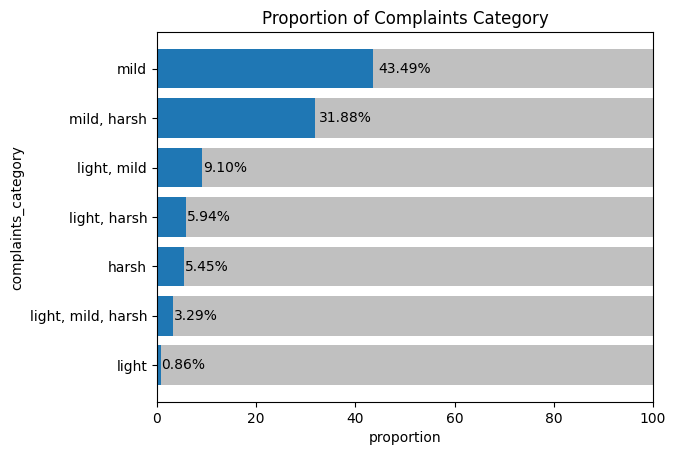

In [4]:
# copy df
df_eda = df_combined.copy()

# group df
df_eda_grouped = df_eda.groupby('combined_labels', as_index=False)['issue'].count()
df_eda_grouped.rename(columns={'issue' : 'amount'}, inplace=True)
df_eda_grouped.sort_values('amount', ascending=True, inplace=True)
df_eda_grouped['amount'] = round((df_eda_grouped['amount'] / df_eda_grouped['amount'].sum()) * 100, 2)

# create plot
plt.barh(data=df_eda_grouped, y='combined_labels', width='amount')
plt.xlim(0, 100)
plt.title('Proportion of Complaints Category')
plt.ylabel('complaints_category')
plt.xlabel('proportion')

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    width = rect.get_width()
    height = rect.get_height()
    ax.text(1.025*width, rect.get_y() + height/2,
            f'{width:.2f}%',
            ha='left', va='center')
    ax.barh(y=rect.get_y() + height/2, width=100, color='silver', zorder=0)

plt.show()

## **What are the average response time of each complaints' category?**

- **Insight:**
    - The likelihood of getting harsh complaints increases as response time increases

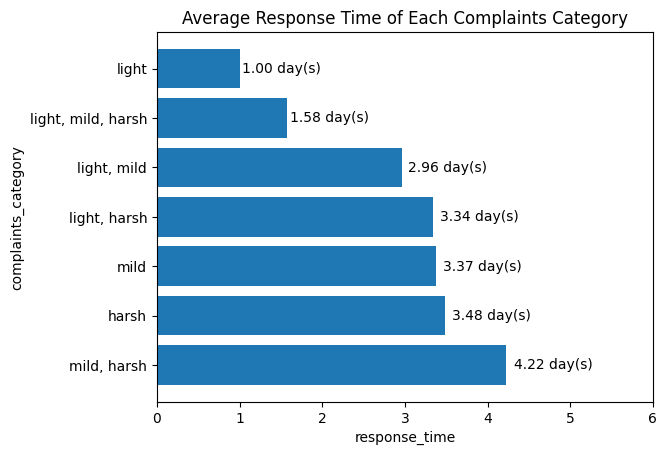

In [5]:
# copy df
df_eda = df_combined.copy()

# get response time
df_eda['response_days'] = (df_eda['date_sent_to_company'] - df_eda['date_received']).dt.days

# group by labels
df_eda_grouped = df_eda.groupby('combined_labels', as_index=False)['response_days'].mean()
df_eda_grouped.sort_values('response_days', ascending=False, inplace=True)

# create plot
plt.barh(data=df_eda_grouped, y='combined_labels', width='response_days')
plt.title('Average Response Time of Each Complaints Category')
plt.ylabel('complaints_category')
plt.xlabel('response_time')
plt.xlim(0, 6)

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    width = rect.get_width()
    height = rect.get_height()
    ax.text(1.025*width, rect.get_y() + height/2,
            f'{width:.2f} day(s)',
            ha='left', va='center')

plt.show()

## **How is the ranking of products by harsh complaints' probability?**

- **Insight:**
    - The ranking of products by harsh complaints' probability is Debt Collection, Payday Loan Product, Student Loan

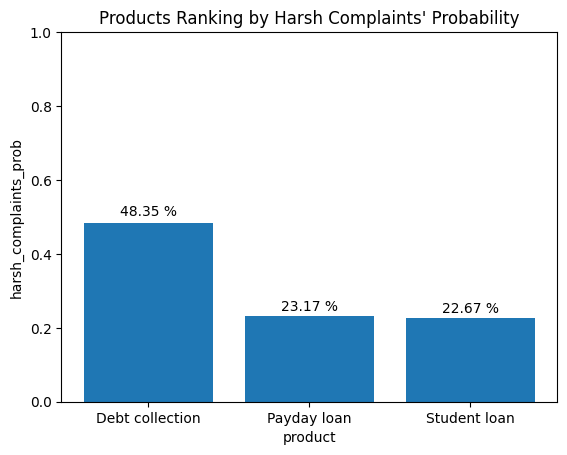

In [6]:
# make a copy of df
df_eda = df_combined.copy()

# group df
df_eda_grouped = df_eda.groupby('product', as_index=False)['harsh_complaints'].mean()
df_eda_grouped.sort_values('harsh_complaints', ascending=False, inplace=True)

# create plot
plt.bar(data=df_eda_grouped, x='product', height='harsh_complaints')
plt.title("Products Ranking by Harsh Complaints' Probability")
plt.ylabel('harsh_complaints_prob')
plt.xlabel('product')
plt.ylim(0, 1)

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    width = rect.get_width()
    height = rect.get_height()
    ax.text(rect.get_x() + width/2, 1.025*height,
            f'{height*100:.2f} %',
            ha='center', va='bottom')

plt.show()

## **What are the top 5 issues with the highest harsh complaints' probability?**

- **Insight:**
    - The top 5 issues with the highest harsh complaints' probability are, 
        - Payment to acct not credited
        - Charged bank acct wrong day or amt
        - Disclosure verification of debt
        - Taking/threatening an illegal action
        - Cont'd attempts collect debt not allowed

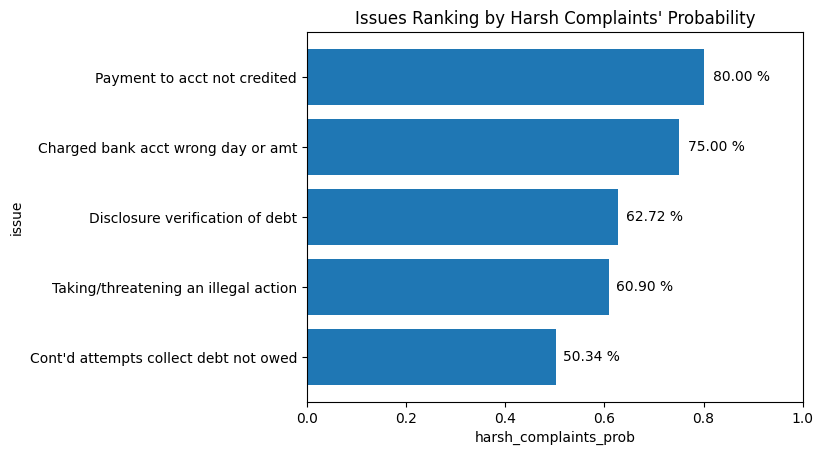

In [7]:
# make a copy of df
df_eda = df_combined.copy()

# group df
df_eda_grouped = df_eda.groupby('issue', as_index=False)['harsh_complaints'].mean()
df_eda_grouped.sort_values('harsh_complaints', ascending=True, inplace=True)
df_eda_grouped = df_eda_grouped.tail(5)

# create plot
plt.barh(data=df_eda_grouped, y='issue', width='harsh_complaints')
plt.title("Issues Ranking by Harsh Complaints' Probability")
plt.xlabel('harsh_complaints_prob')
plt.ylabel('issue')
plt.xlim(0, 1)

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    width = rect.get_width()
    height = rect.get_height()
    ax.text(1.025*width, rect.get_y() + height/2, 
            f'{width*100:.2f} %',
            ha='left', va='center')

plt.show()

## **What are the top 5 states with the highest harsh complaints' probability?**

- **Insight:**
    - The top 5 states with the highest harsh complaints' probability are, 
        - West Virginia, Delaware, Nebraska, Alabama, Minnesota

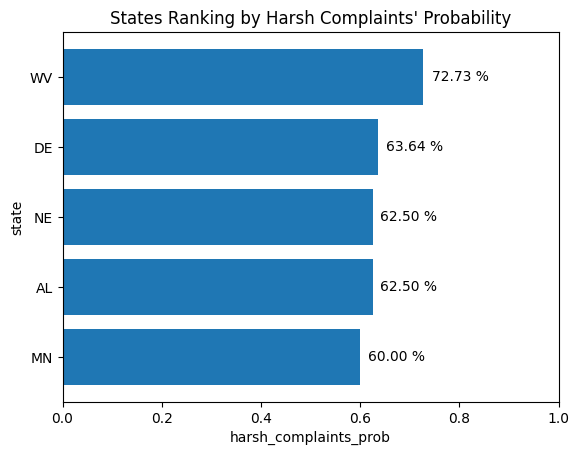

In [8]:
# make a copy of df
df_eda = df_combined.copy()

# group df
df_eda_grouped = df_eda.groupby('state', as_index=False)['harsh_complaints'].mean()
df_eda_grouped.sort_values('harsh_complaints', ascending=True, inplace=True)
df_eda_grouped = df_eda_grouped.tail(5)

# create plot
plt.barh(data=df_eda_grouped, y='state', width='harsh_complaints')
plt.title("States Ranking by Harsh Complaints' Probability")
plt.xlabel('harsh_complaints_prob')
plt.ylabel('state')
plt.xlim(0, 1)

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    width = rect.get_width()
    height = rect.get_height()
    ax.text(1.025*width, rect.get_y() + height/2, 
            f'{width*100:.2f} %',
            ha='left', va='center')

plt.show()

## **What are some words that stands out in light complaints and harsh complaints?**

- **Insight:**
    - Some words that stand out are, 
        - Light: please, thank, help
        - Harsh: theft, illegal, threatening

In [9]:
# define stopword, punctuation, and excluded words (too common)
nltk_stopword = set(stopwords.words('english'))
str_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
excluded_words = {'xx', 'xxxx', 'debt', 'wa', 'collect', 'collection', 'account', 'credit', 'company', 'agency', 'nt', 'ha',
                  'attempt', 'owed', 'contd', 'report', 'received', 'call', 'mine', 'letter', 'paid', 'pay', 'payment', 'information',
                  'number', 'phone', 'interest', 'loan', 'year', 'sp', 'doctor', 'sps', 'j', 'hanna', 'llp', 'h', 'never', 'time', 'sent', 'bill',
                  'called', 'owe', 'told', 'contact', 'service', 'amount'}

# define lemmatizer
lemmatizer = WordNetLemmatizer()

# create a function for text preprocessing
def text_preprocessing(text):
  # case folding
  text = text.lower()

  # mention removal
  text = re.sub("@[a-za-z0-9_]+", " ", text)

  # hashtags removal
  text = re.sub("#[a-za-z0-9_]+", " ", text)

  # newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # whitespace removal
  text = text.strip()

  # url removal
  text = re.sub(r"http\s+", " ", text)
  text = re.sub(r"www.\s+", " ", text)

  # non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^a-za-z\s']", " ", text)
  text = re.sub("'", "", text)

  # tokenization
  tokens = word_tokenize(text)

  # stopwords removal
  # tokens = [word for word in tokens if word not in nltk_stopword]

  # lemmatizing
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # excluded words removal
  # tokens = [word for word in tokens if word not in excluded_words]
  tokens = [word for word in tokens if (word not in nltk_stopword) and (word not in excluded_words)]

  # combining tokens
  text = ' '.join(tokens)

  return text

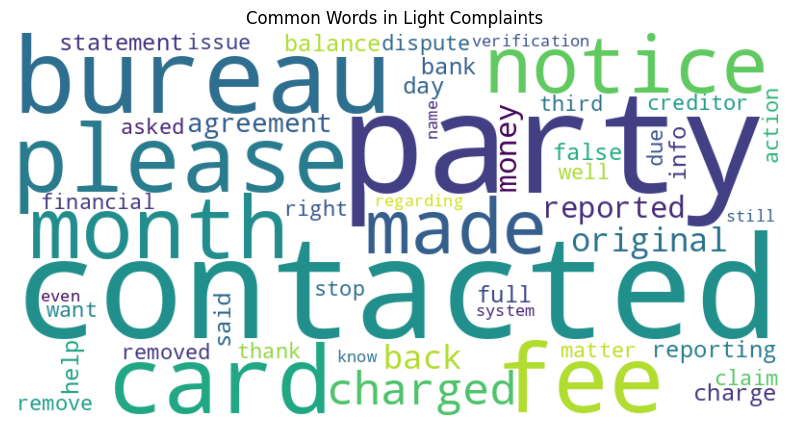

In [10]:
# copy df
df_eda = df_combined.copy()

words_preprocessed = df_eda['sentence'][df_eda['combined_labels'].str.contains('light')].apply(lambda x: text_preprocessing(x))

words_flatten = ''
for w in words_preprocessed:
    words_flatten += w
    words_flatten += ' '

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, collocations=False).generate(words_flatten)
plt.figure(figsize=(10, 5))
plt.title('Common Words in Light Complaints')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

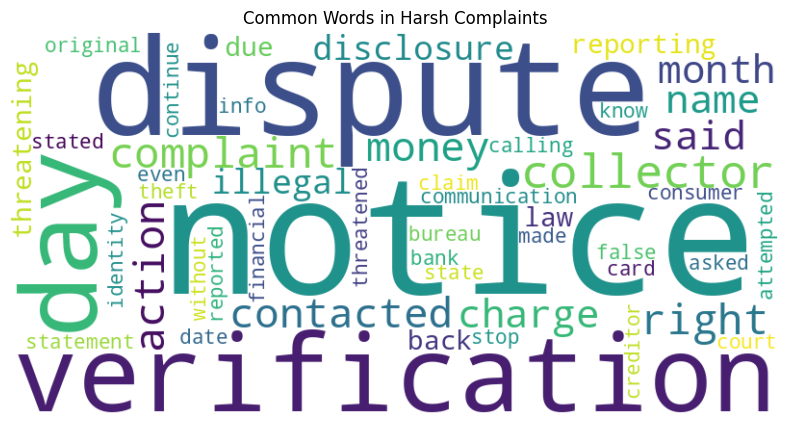

In [11]:
# copy df
df_eda = df_combined.copy()

words_preprocessed = df_eda['sentence'][df_eda['combined_labels'].str.contains('harsh')].apply(lambda x: text_preprocessing(x))

words_flatten = ''
for w in words_preprocessed:
    words_flatten += w
    words_flatten += ' '

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, collocations=False).generate(words_flatten)
plt.figure(figsize=(10, 5))
plt.title('Common Words in Harsh Complaints')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Insights summary:**
- Most complaints are mild, mild-harsh, or mild-light
- The likelihood of getting harsh complaints increases as response time increases
- The ranking of products by harsh complaints' probability is Debt Collection, Payday Loan Product, Student Loan
- The top 5 issues with the highest harsh complaints' probability are, 
    - Payment to acct not credited
    - Charged bank acct wrong day or amt
    - Disclosure verification of debt
    - Taking/threatening an illegal action
    - Cont'd attempts collect debt not allowed
- The top 5 states with the highest harsh complaints' probability are, 
    - West Virginia, Delaware, Nebraska, Alabama, Minnesota
- Some words that stand out are, 
    - Light: please, thank, help
    - Harsh: theft, illegal, threatening

## **Recommendations:**
- To investigate what caused longer response time, and find ways on how to improve it
- To prioritize complaints from products in this order, Debt Collection -> Payday Loan Product -> Student Loan
- To prioritize complaints with these issues, 
    - Payment to acct not credited
    - Charged bank acct wrong day or amt
    - Disclosure verification of debt
    - Taking/threatening an illegal action
    - Cont'd attempts collect debt not allowed
- To prioritize complaints from these states,
    - West Virginia, Delaware, Nebraska, Alabama, Minnesota